In [31]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Path("plots").mkdir(exist_ok=True)
Path("outputs").mkdir(exist_ok=True)








In [32]:
def try_transpose_if_needed(df):
    """
    If df looks transposed (few rows, many cols and first column has field names),
    convert it to a records DataFrame where each row is a trade.
    """

    if df.shape[0] < 10 and df.shape[1] > 5:

        first_col_values = df.iloc[:, 0].astype(str).str.lower()

        if any(x in " ".join(first_col_values.values) for x in ['account', 'execution', 'closed', 'timestamp', 'size', 'coin', 'side']):
            fields = df.iloc[:, 0].fillna('').astype(str).str.strip().tolist()

            body = df.drop(df.columns[0], axis=1).T.reset_index(drop=True)
            body.columns = fields
            return body
    return df


In [14]:
def find_column(df, candidates):
    """Return the first column name in df that matches any candidate (case-insensitive, partial OK)."""
    low_map = {col.lower().strip(): col for col in df.columns}
    for cand in candidates:
        cand_l = cand.lower().strip()
        # exact or contains
        for k, orig in low_map.items():
            if k == cand_l or cand_l in k or k in cand_l:
                return orig
    return None

In [15]:
def parse_datetime_series(s):
    """
    Try to parse a pandas Series s into datetimes robustly:
    - If values are numeric: infer seconds vs ms vs ns
    - Else try common string formats with dayfirst=True then fallback
    Returns a datetime Series (tz-naive)
    """

    s_num = pd.to_numeric(s, errors='coerce')
    if s_num.notna().sum() > 0:
        med = float(s_num.dropna().median())

        if med > 1e14:
            unit = 'ns'
        elif med > 1e11:
            unit = 'ms'
        elif med > 1e9:
            unit = 's'
        else:
            unit = None

        if unit is not None:
            try:
                return pd.to_datetime(s_num, unit=unit, errors='coerce')
            except Exception:
                pass

    parsed = pd.to_datetime(s.astype(str).str.strip(), dayfirst=True, errors='coerce')
    if parsed.notna().sum() > 0:
        return parsed

    return pd.to_datetime(s, errors='coerce')

In [17]:
hist_path = "/content/historical_data.csv"
fg_path = "/content/fear_greed_index.csv"

print("Loading historical file:", hist_path)
hist_raw = pd.read_csv(hist_path, low_memory=False)
print("Raw shape:", hist_raw.shape)

hist = try_transpose_if_needed(hist_raw)
print("After transpose check shape:", hist.shape)

hist.columns = [str(c).strip() for c in hist.columns]

print("Historical columns:", hist.columns.tolist()[:30])

Loading historical file: /content/historical_data.csv
Raw shape: (211224, 16)
After transpose check shape: (211224, 16)
Historical columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [18]:
print("\nLoading fear/greed file:", fg_path)
fg_raw = pd.read_csv(fg_path, low_memory=False)
print("Raw FG shape:", fg_raw.shape)

fg = try_transpose_if_needed(fg_raw)
print("After transpose check FG shape:", fg.shape)
fg.columns = [str(c).strip() for c in fg.columns]
print("FG columns:", fg.columns.tolist()[:20])



Loading fear/greed file: /content/fear_greed_index.csv
Raw FG shape: (2644, 4)
After transpose check FG shape: (2644, 4)
FG columns: ['timestamp', 'value', 'classification', 'date']


In [19]:

hist_time_col = find_column(hist, ['Timestamp IST', 'Timestamp', 'time', 'timestamp', 'datetime', 'date'])
if hist_time_col is None:
    raise ValueError("No time-like column found in historical data. Columns found: " + ", ".join(hist.columns))
print("Using historical time column:", hist_time_col)

hist['time'] = parse_datetime_series(hist[hist_time_col])
print("Parsed historical times, valid count:", hist['time'].notna().sum(), " / ", len(hist))

if hist['time'].isna().sum() == len(hist):

    try:
        hist['time'] = pd.to_datetime(hist[hist_time_col], format='%d-%m-%Y %H:%M', errors='coerce')
        print("Tried explicit format dd-mm-YYYY HH:MM, valid:", hist['time'].notna().sum())
    except Exception:
        pass

hist = hist.dropna(subset=['time']).reset_index(drop=True)
print("Historical after dropping invalid times:", hist.shape)

fg_time_col = find_column(fg, ['date', 'Date', 'timestamp', 'time'])
if fg_time_col is None:
    raise ValueError("No date-like column found in Fear/Greed data. Columns: " + ", ".join(fg.columns))
print("Using FG date column:", fg_time_col)

fg['date_parsed'] = parse_datetime_series(fg[fg_time_col])
print("Parsed FG dates valid:", fg['date_parsed'].notna().sum(), " / ", len(fg))


if fg['date_parsed'].isna().sum() == len(fg):
    fg['date_parsed'] = pd.to_datetime(fg[fg_time_col], dayfirst=True, errors='coerce')

fg = fg.dropna(subset=['date_parsed']).reset_index(drop=True)
fg['fg_date'] = fg['date_parsed'].dt.date

Using historical time column: Timestamp IST
Parsed historical times, valid count: 211224  /  211224
Historical after dropping invalid times: (211224, 17)
Using FG date column: date
Parsed FG dates valid: 1046  /  2644


In [20]:

closed_col = find_column(hist, ['closed pnl', 'closedpnl', 'pnl', 'profit', 'closed_pnl'])
if closed_col:
    hist['closedPnL'] = pd.to_numeric(hist[closed_col], errors='coerce')
else:
    hist['closedPnL'] = np.nan
print("Using closedPnL column:", closed_col, "non-null count:", hist['closedPnL'].notna().sum())


lev_col = find_column(hist, ['leverage', 'lev'])
if lev_col:
    hist['leverage'] = pd.to_numeric(hist[lev_col], errors='coerce')
    print("Leverage parsed, non-null:", hist['leverage'].notna().sum())
else:
    hist['leverage'] = np.nan

# side normalization
side_col = find_column(hist, ['side', 'direction'])
if side_col:
    hist['side'] = hist[side_col].astype(str).str.lower().str.strip()
    print("Side sample:", hist['side'].unique()[:5])
else:
    hist['side'] = None

# size: tokens or USD
size_col = find_column(hist, ['size tokens', 'size_tokens', 'size', 'size usd', 'size_usd'])
if size_col:
    hist['size'] = pd.to_numeric(hist[size_col], errors='coerce')
    print("Size parsed from:", size_col)
else:
    hist['size'] = np.nan

# Add trade_date column for aggregation
hist['trade_date'] = hist['time'].dt.date

Using closedPnL column: Closed PnL non-null count: 211224
Side sample: ['buy' 'sell']
Size parsed from: Size Tokens


In [21]:
# value numeric column candidates
fg_value_col = find_column(fg, ['value', 'Value', 'index', 'Index', 'sentiment_value'])
if fg_value_col:
    fg['sentiment_value'] = pd.to_numeric(fg[fg_value_col], errors='coerce')
    print("Found FG numeric column:", fg_value_col)
else:
    fg['sentiment_value'] = np.nan

# classification mapping if value missing
if fg['sentiment_value'].isna().all():
    class_col = find_column(fg, ['classification', 'Classification', 'class'])
    mapping = {
        'extreme fear': 0,
        'fear': 1,
        'neutral': 2,
        'greed': 3,
        'extreme greed': 4
    }
    if class_col:
        fg['class_clean'] = fg[class_col].astype(str).str.lower().str.strip()
        fg['sentiment_value'] = fg['class_clean'].map(mapping)
        print("Mapped FG classification to numeric using column:", class_col)
    else:

        fg['sentiment_value'] = pd.qcut(range(len(fg)), 5, labels=False)
        print("Fallback: created quantile-based sentiment_value")

fg_small = fg.groupby('fg_date', as_index=False).agg(sentiment_value=('sentiment_value', 'mean'))
print("FG small (date -> sentiment) shape:", fg_small.shape)


Found FG numeric column: value
FG small (date -> sentiment) shape: (1046, 2)


In [22]:

hist['profit_flag'] = (hist['closedPnL'] > 0).astype(int)

daily = hist.groupby('trade_date').agg(
    total_pnl=('closedPnL', 'sum'),
    avg_pnl=('closedPnL', 'mean'),
    median_pnl=('closedPnL', 'median'),
    win_rate=('profit_flag', 'mean'),
    n_trades=('closedPnL', 'count'),
    avg_leverage=('leverage', 'mean')
).reset_index()

# merge with FG
daily = daily.merge(fg_small, left_on='trade_date', right_on='fg_date', how='left')
print("Daily aggregated shape:", daily.shape)
daily.to_csv('outputs/daily_aggregated_metrics.csv', index=False)
print("Saved outputs/daily_aggregated_metrics.csv")

Daily aggregated shape: (480, 9)
Saved outputs/daily_aggregated_metrics.csv


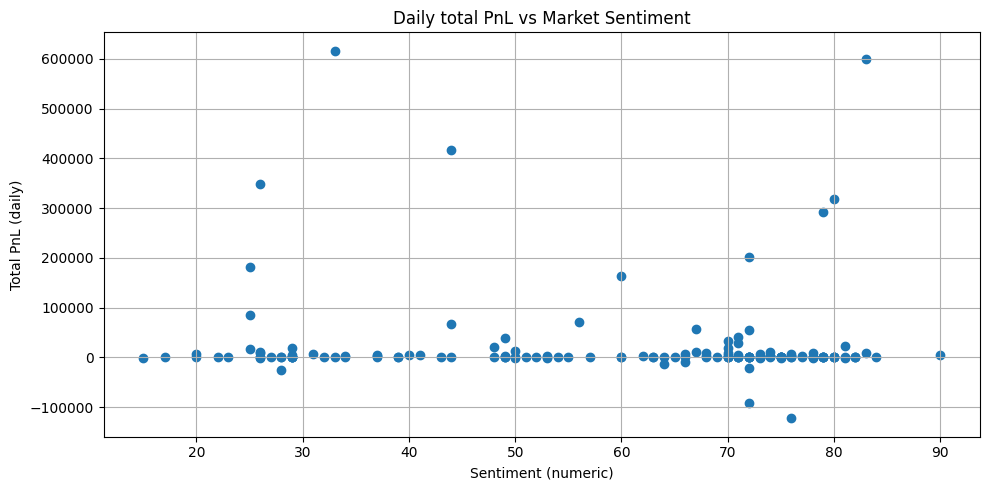

In [27]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.scatter(daily['sentiment_value'], daily['total_pnl'])
plt.xlabel('Sentiment (numeric)')
plt.ylabel('Total PnL (daily)')
plt.title('Daily total PnL vs Market Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()

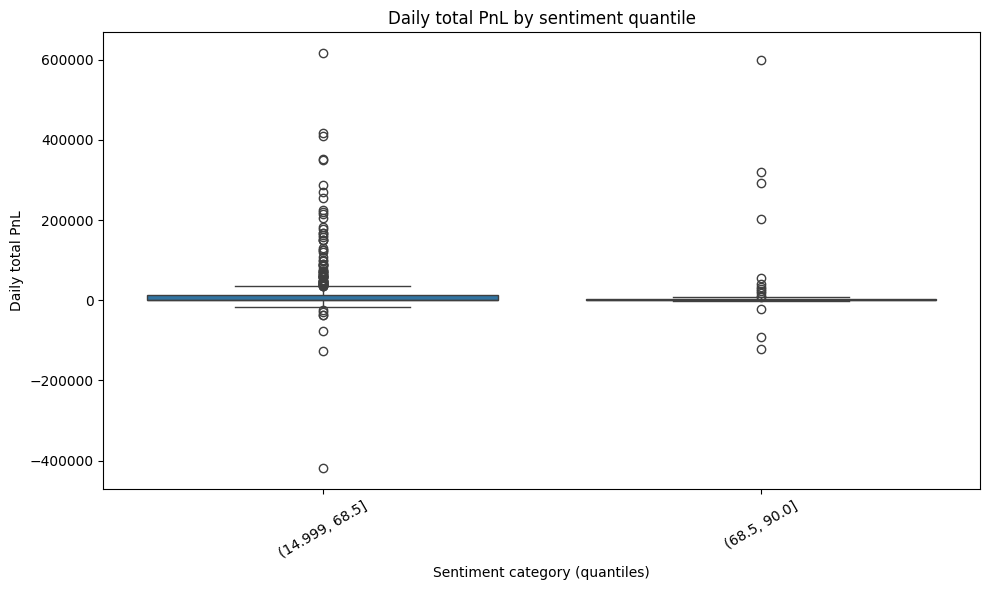

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

if daily['sentiment_value'].notna().any():

    daily['sent_cat'] = pd.qcut(
        daily['sentiment_value'].fillna(daily['sentiment_value'].median()),
        q=5,
        duplicates='drop'
    )

    plt.figure(figsize=(10,6))
    sns.boxplot(x='sent_cat', y='total_pnl', data=daily)
    plt.xticks(rotation=30)
    plt.xlabel('Sentiment category (quantiles)')
    plt.ylabel('Daily total PnL')
    plt.title('Daily total PnL by sentiment quantile')
    plt.tight_layout()
    plt.show()

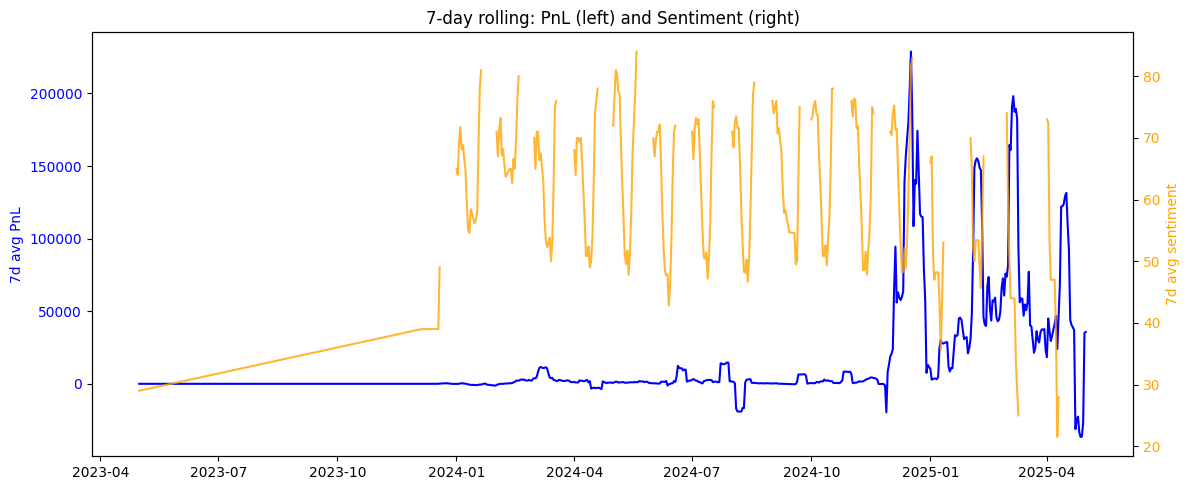

In [29]:

if len(daily) >= 7 and 'sentiment_value' in daily.columns:
    daily_sorted = daily.sort_values('trade_date')
    daily_sorted['pnl_7d'] = daily_sorted['total_pnl'].rolling(7, min_periods=1).mean()
    daily_sorted['sent_7d'] = daily_sorted['sentiment_value'].rolling(7, min_periods=1).mean()

    fig, ax1 = plt.subplots(figsize=(12,5))
    ax1.plot(daily_sorted['trade_date'], daily_sorted['pnl_7d'], label='PnL 7d', color='blue')
    ax1.set_ylabel('7d avg PnL', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(daily_sorted['trade_date'], daily_sorted['sent_7d'], label='Sentiment 7d', color='orange', alpha=0.8)
    ax2.set_ylabel('7d avg sentiment', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title('7-day rolling: PnL (left) and Sentiment (right)')
    fig.tight_layout()
    plt.show()



In [30]:

valid = daily.dropna(subset=['sentiment_value', 'total_pnl'])
if len(valid) >= 3:
    pearson_r, pearson_p = stats.pearsonr(valid['sentiment_value'], valid['total_pnl'])
    spearman_r, spearman_p = stats.spearmanr(valid['sentiment_value'], valid['total_pnl'])
    print("\nCorrelation results:")
    print(f"Pearson r = {pearson_r:.4f}, p = {pearson_p:.4g}")
    print(f"Spearman r = {spearman_r:.4f}, p = {spearman_p:.4g}")
else:
    print("Not enough valid daily rows to compute correlations.")




Correlation results:
Pearson r = -0.0573, p = 0.4749
Spearman r = -0.0208, p = 0.7958
